# 🔋 Energy Trading Optimization - Team KDM
### Hybrid Solution: Ensemble Machine Learning + Global MILP Optimization

**Overview:**
This solution addresses the challenge of maximizing profit from a virtual battery storage system over an 8-day horizon. We combine high-precision price forecasting with rigorous mathematical optimization.

**Methodology Pipeline:**
1.  **Feature Engineering:** Advanced Fourier transforms for cyclical patterns and stable lag features to capture market trends without recursive drift.
2.  **Price Forecasting:** An iterative prediction loop using a weighted ensemble of **LightGBM** and **XGBoost**.
3.  **Global Optimization:** A Mixed-Integer Linear Programming (MILP) solver (**PuLP**) determines the optimal charge/discharge schedule, respecting all physical constraints and daily resets.

### Imports and Global Data

In [2]:
import warnings
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
import pulp
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from tqdm.notebook import tqdm
from typing import List, Tuple

# Visual settings and warning suppression
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (15, 6)

# ==========================================
# GLOBAL CONFIGURATION
# ==========================================
class Config:
    # Competition Constraints
    NUM_DAYS = 8
    INTERVALS_PER_HOUR = 4
    INTERVALS_PER_DAY = 24 * INTERVALS_PER_HOUR
    TOTAL_INTERVALS = NUM_DAYS * INTERVALS_PER_DAY
    
    # Battery Specs
    C_MAX = 10.0          # Capacity (MWh)
    P_MAX = 10.0          # Max Power (MWh per interval)
    SOC_START = 5.0       # Initial State of Charge (MWh)
    MIN_TRANSACTION = 0.1 # Minimum trading volume (MWh)
    
    # Solver Parameters (Safety margins for numerical stability)
    SOC_MIN_MILP = 0.001
    SOC_MAX_MILP = C_MAX - 0.001
    
    # Model Parameters
    SMOOTHING_WINDOW = 2  # 30-min window for noise reduction
    ALPHA_LGBM = 0.5      # Ensemble weight for LightGBM
    ALPHA_XGB = 0.5       # Ensemble weight for XGBoost
    
    # File Paths
    DATA_PATH = 'Dataset.csv'
    OUTPUT_PATH = 'submission.csv'

print("Configuration loaded.")

Configuration loaded.


### Feature Engineering

In [4]:
def create_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Generates temporal, cyclical (Fourier), and statistical lag features.
    Crucially, it uses only stable historical lags to prevent recursive error drift.
    """
    # Timestamp Conversion
    if 'Start' not in df.columns:
        # Expected format: 'dd.mm.yyyy HH:MM - ...'
        df['Start'] = pd.to_datetime(
            df['Time interval (CET/CEST)'].str.split(' - ').str[0], 
            format="%d.%m.%Y %H:%M"
        )

    # 1. Base Temporal Features
    df['hour'] = df['Start'].dt.hour
    df['minute'] = df['Start'].dt.minute
    df['dow'] = df['Start'].dt.dayofweek
    df['month'] = df['Start'].dt.month
    df['is_weekend'] = (df['dow'] >= 5).astype(int)

    # 2. Fourier Harmonics (Capturing daily double-peak patterns)
    # Continuous time representation
    time_of_day = df['hour'] + df['minute'] / 60
    
    # 24-hour cycle (Standard)
    df['sin_24h'] = np.sin(2 * np.pi * time_of_day / 24)
    df['cos_24h'] = np.cos(2 * np.pi * time_of_day / 24)
    
    # 12-hour cycle (Captures morning/evening peaks)
    df['sin_12h'] = np.sin(2 * np.pi * time_of_day * 2 / 24)
    df['cos_12h'] = np.cos(2 * np.pi * time_of_day * 2 / 24)
    
    # 8-hour cycle (Finer intraday detail)
    df['sin_8h'] = np.sin(2 * np.pi * time_of_day * 3 / 24)
    df['cos_8h'] = np.cos(2 * np.pi * time_of_day * 3 / 24)
    
    # Weekly Cycle
    df['sin_dow'] = np.sin(2 * np.pi * df['dow'] / 7)
    df['cos_dow'] = np.cos(2 * np.pi * df['dow'] / 7)
    
    # 3. Lag Features (Target-based)
    if 'Price' in df.columns:
        # Stable Lags (Known history)
        df['lag_24h'] = df['Price'].shift(96)      # Exactly 24h ago
        df['lag_12h'] = df['Price'].shift(48)      # 12h ago
        df['lag_7d']  = df['Price'].shift(672)     # 1 week ago
        
        # Deep Context Lags
        df['lag_48h'] = df['Price'].shift(192)     # 2 days ago
        df['lag_3_5d'] = df['Price'].shift(336)    # 3.5 days ago
        
        # Rolling Statistics on Lags (Safe Context)
        # "What was the average price around this time yesterday?"
        # Window=4 (1 hour) centered on the 24h lag
        df['roll_mean_lag24h'] = df['lag_24h'].rolling(window=4, center=True, min_periods=1).mean()
        df['roll_std_lag24h'] = df['lag_24h'].rolling(window=4, center=True, min_periods=1).std()

    return df.dropna().reset_index(drop=True)

print("Feature Engineering pipeline defined.")

Feature Engineering pipeline defined.


### Model Training

In [5]:
# Load and Preprocess Data
df_raw = pd.read_csv(Config.DATA_PATH)
df_raw = df_raw.sort_values(by='Time interval (CET/CEST)', 
                            key=lambda x: pd.to_datetime(x.str.split(' - ').str[0], format="%d.%m.%Y %H:%M")
                           ).reset_index(drop=True)

# Generate Training Dataset
df_train = create_features(df_raw.copy())

# Define Features and Target
EXCLUDE_COLS = ['Time interval (CET/CEST)', 'Start', 'Price']
FEATURE_COLS = [col for col in df_train.columns if col not in EXCLUDE_COLS]
TARGET = 'Price'

print(f"Training Data Shape: {df_train.shape}")
print(f"Active Features ({len(FEATURE_COLS)}): {FEATURE_COLS}")

# Train/Validation Split (Last 24h as validation set)
split_idx = len(df_train) - 96
X_train, y_train = df_train.iloc[:split_idx][FEATURE_COLS], df_train.iloc[:split_idx][TARGET]
X_val, y_val = df_train.iloc[split_idx:][FEATURE_COLS], df_train.iloc[split_idx:][TARGET]

# --- 1. LightGBM Regressor ---
print("\nTraining LightGBM...")
lgbm = lgb.LGBMRegressor(
    n_estimators=800,
    learning_rate=0.015,
    num_leaves=128,
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1.0,
    reg_lambda=2.0,
    n_jobs=-1,
    random_state=42
)
lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='mae',
         callbacks=[lgb.early_stopping(50, verbose=False)])

# --- 2. XGBoost Regressor ---
print("Training XGBoost...")
xgb_model = xgb.XGBRegressor(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=8,
    n_jobs=-1,
    random_state=42
)
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

print("\nEnsemble models trained successfully.")

📊 Training Data Shape: (165216, 23)
🔧 Active Features (20): ['hour', 'minute', 'dow', 'month', 'is_weekend', 'sin_24h', 'cos_24h', 'sin_12h', 'cos_12h', 'sin_8h', 'cos_8h', 'sin_dow', 'cos_dow', 'lag_24h', 'lag_12h', 'lag_7d', 'lag_48h', 'lag_3_5d', 'roll_mean_lag24h', 'roll_std_lag24h']

🚀 Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2256
[LightGBM] [Info] Number of data points in the train set: 165120, number of used features: 20
[LightGBM] [Info] Start training from score 598.067287
🚀 Training XGBoost...

✅ Ensemble models trained successfully.


### Iterative Forecasting

In [6]:
# Prepare Future Timestamp Index
last_timestamp = pd.to_datetime(df_raw['Time interval (CET/CEST)'].iloc[-1].split(' - ')[0], format="%d.%m.%Y %H:%M")
future_dates = [last_timestamp + timedelta(minutes=15 * (i + 1)) for i in range(Config.TOTAL_INTERVALS)]

df_pred = pd.DataFrame({'Start': future_dates})
df_pred['Time interval (CET/CEST)'] = df_pred['Start'].dt.strftime("%d.%m.%Y %H:%M")

# Initialize Prediction Template
df_pred_template = create_features(df_pred.copy())
full_history = df_train[TARGET].tolist()
predicted_prices = []

print("Generating 8-Day Forecast (Iterative)...")

for i in tqdm(range(Config.TOTAL_INTERVALS)):
    current_idx = len(full_history) - 1
    row = df_pred_template.iloc[[i]].copy()
    
    # Update Stable Lags from History (Non-recursive lookup)
    row['lag_24h'] = full_history[current_idx - 95]
    row['lag_12h'] = full_history[current_idx - 47]
    row['lag_7d']  = full_history[current_idx - 671]
    row['lag_48h'] = full_history[current_idx - 191]
    row['lag_3_5d'] = full_history[current_idx - 335]
    
    # Update Rolling Stats on Lags
    # Window centered on t-96 (yesterday same time)
    center_idx = current_idx - 95
    hist_window = full_history[center_idx - 2 : center_idx + 2]
    row['roll_mean_lag24h'] = np.mean(hist_window)
    row['roll_std_lag24h'] = np.std(hist_window)
    
    # Ensemble Prediction
    p1 = lgbm.predict(row[FEATURE_COLS])[0]
    p2 = xgb_model.predict(row[FEATURE_COLS])[0]
    final_pred = (Config.ALPHA_LGBM * p1) + (Config.ALPHA_XGB * p2)
    
    predicted_prices.append(final_pred)
    full_history.append(final_pred)

df_pred['Predicted_Price'] = predicted_prices

# Apply Smoothing to reduce noise for the optimizer
df_pred['Smoothed_Price'] = df_pred['Predicted_Price'].rolling(window=Config.SMOOTHING_WINDOW, min_periods=1).mean()

print("Forecasting complete.")

Generating 8-Day Forecast (Iterative)...


  0%|          | 0/768 [00:00<?, ?it/s]

Forecasting complete.


### Global Optimization

In [8]:
def solve_global_optimization(prices: List[float]) -> List[float]:
    """
    Solves the global energy arbitrage problem using Mixed-Integer Linear Programming (MILP).
    Optimizes for total profit over the entire horizon while respecting daily resets.
    """
    T = len(prices)
    prob = pulp.LpProblem("Energy_Arbitrage_Global", pulp.LpMaximize)
    
    # Decision Variables
    pos = pulp.LpVariable.dicts("Pos", range(T), -Config.P_MAX, Config.P_MAX)
    soc = pulp.LpVariable.dicts("SoC", range(T), Config.SOC_MIN_MILP, Config.SOC_MAX_MILP)
    charge = pulp.LpVariable.dicts("Chg", range(T), cat='Binary')
    discharge = pulp.LpVariable.dicts("Dch", range(T), cat='Binary')
    
    # Objective Function Construction
    total_profit = 0
    
    for d in range(Config.NUM_DAYS):
        start_idx, end_idx = d * 96, (d + 1) * 96
        daily_prices = prices[start_idx:end_idx]
        p_min_day = min(daily_prices)
        
        # 1. Trading Profit (Revenue - Cost)
        # Note: Position > 0 is Buying (Cost), Position < 0 is Selling (Revenue)
        # We maximize: Sum( -Position * Price ) -> equivalent to Selling High, Buying Low
        # However, standard convention: Sum(Pos * Price) is cost. 
        # We subtract this cost.
        daily_txn_cost = pulp.lpSum([pos[t] * prices[t] for t in range(start_idx, end_idx)])
        
        # 2. End-of-Day Surplus Sale
        # SoC at 00:00 next day (computed from last interval) is sold at P_min
        surplus = soc[end_idx-1] + pos[end_idx-1]
        surplus_revenue = surplus * p_min_day
        
        total_profit += (surplus_revenue - daily_txn_cost)
        
        # Constraint: Daily Reset to 5.0 MWh at 00:00 of the NEXT day
        if d < Config.NUM_DAYS - 1:
            prob += soc[end_idx] == Config.SOC_START

    prob += total_profit, "Maximize_Total_Profit"

    # Initial State Constraint
    prob += soc[0] == Config.SOC_START
    
    # Constraints per Interval
    for t in range(T):
        # 1. Flow Balance (SoC_next = SoC_curr + Action)
        # We don't link across midnight boundaries here (handled by Reset constraint)
        if (t + 1) % 96 != 0:
            prob += soc[t+1] == soc[t] + pos[t], f"Flow_{t}"
            
        # 2. Capacity Limits (Redundant but safe)
        prob += soc[t] + pos[t] <= Config.SOC_MAX_MILP, f"CapMax_{t}"
        prob += soc[t] + pos[t] >= Config.SOC_MIN_MILP, f"CapMin_{t}"
        
        # 3. Transaction Logic (Mutually Exclusive & Minimum Size)
        prob += charge[t] + discharge[t] == 1, f"Bin_{t}"
        prob += pos[t] >= Config.MIN_TRANSACTION * charge[t] - Config.P_MAX * discharge[t], f"LB_{t}"
        prob += pos[t] <= Config.P_MAX * charge[t] - Config.MIN_TRANSACTION * discharge[t], f"UB_{t}"

    # Solve
    print("Solving MILP...")
    solver = pulp.PULP_CBC_CMD(msg=0) # Silent solver
    prob.solve(solver)
    
    if pulp.LpStatus[prob.status] == "Optimal":
        return [pos[t].varValue for t in range(T)]
    
    print("Optimization Failed! Returning zero actions.")
    return [0.0] * T

print("Starting Global Optimization...")
optimal_actions = solve_global_optimization(df_pred['Smoothed_Price'].tolist())
df_pred['Position'] = optimal_actions
print("Optimization Finished.")

Starting Global Optimization...
Solving MILP...
Optimization Finished.


### Visualization (Strategy Analysis)

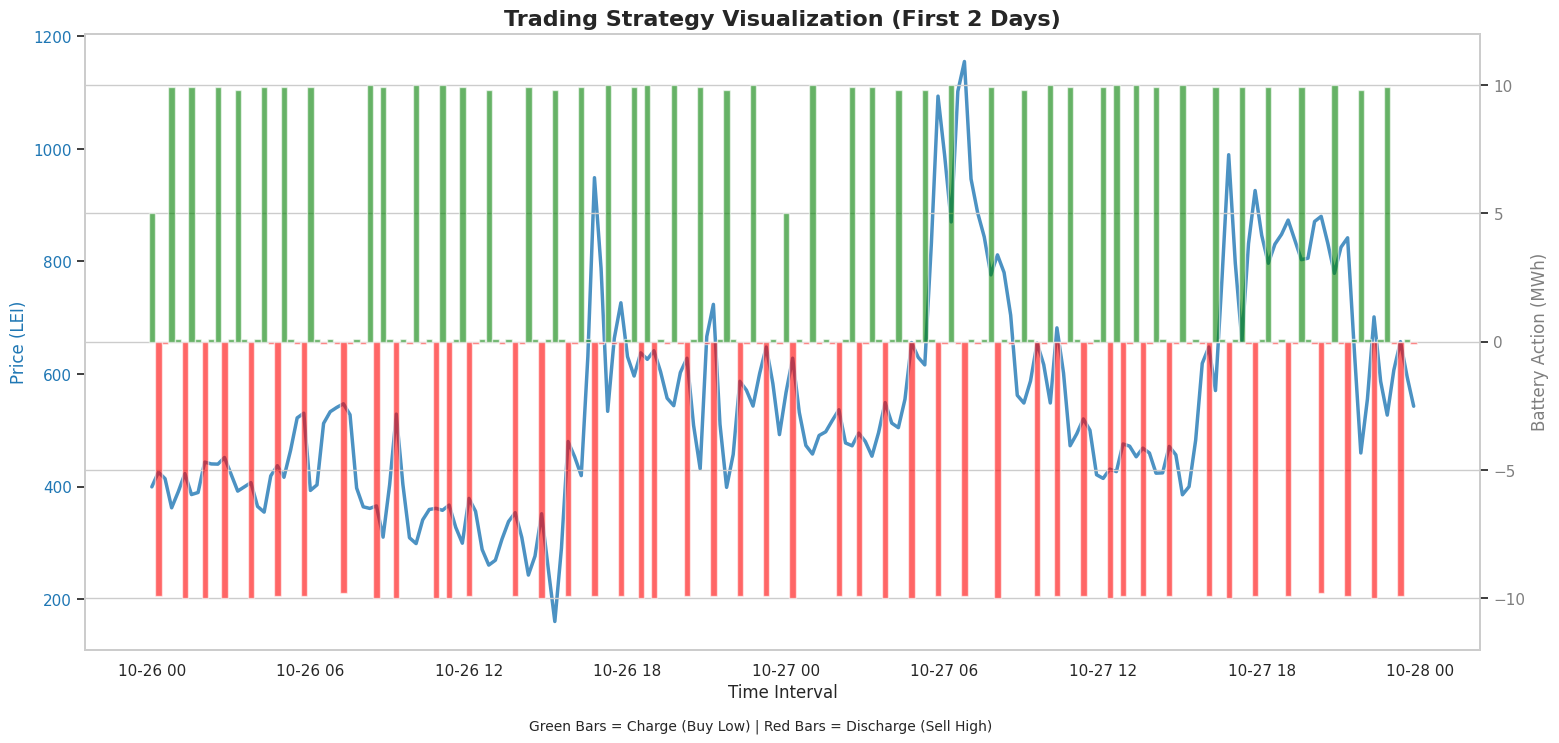

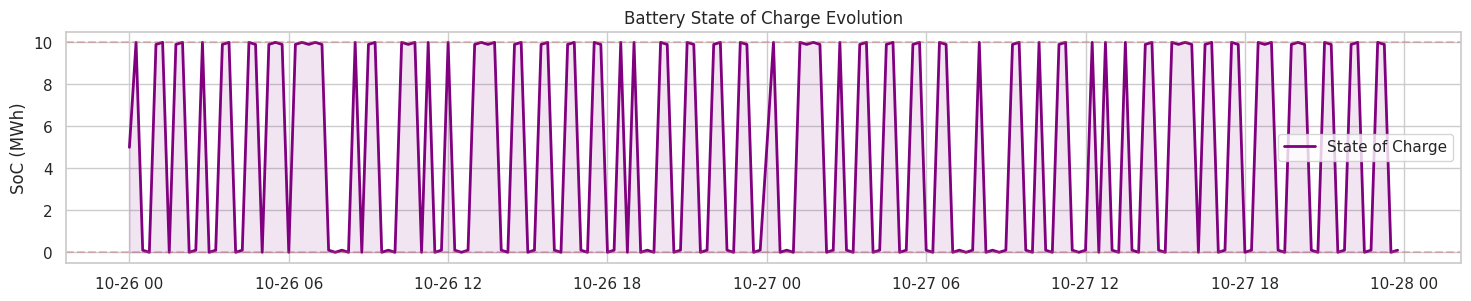

In [9]:
# Visualize Strategy for the first 2 Days
plot_days = 2
intervals = plot_days * 96
subset = df_pred.iloc[:intervals].copy()

# Simulate SoC for plotting
soc_sim = [Config.SOC_START]
for p in subset['Position'].values[:-1]:
    # Simple logic: SoC_next = SoC_curr + Action (Clamped 0-10)
    # Note: Does not perfectly reflect daily reset logic in plot, but good for visualization
    next_soc = max(0, min(10, soc_sim[-1] + p))
    # Reset visual if crossing midnight
    if len(soc_sim) % 96 == 0: 
        next_soc = 5.0
    soc_sim.append(next_soc)
subset['SoC_Visual'] = soc_sim

# Create Plot
fig, ax1 = plt.subplots(figsize=(18, 8))

# Price Line
color = 'tab:blue'
ax1.set_xlabel('Time Interval')
ax1.set_ylabel('Price (LEI)', color=color, fontsize=12)
ax1.plot(subset['Start'], subset['Smoothed_Price'], color=color, label='Forecasted Price', linewidth=2.5, alpha=0.8)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(False)

# Action Bars
ax2 = ax1.twinx()
color = 'tab:gray'
ax2.set_ylabel('Battery Action (MWh)', color=color, fontsize=12)
# Green = Charge (Buy), Red = Discharge (Sell)
colors = ['green' if x > 0 else 'red' for x in subset['Position']]
ax2.bar(subset['Start'], subset['Position'], color=colors, alpha=0.6, width=0.01, label='Action')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(-12, 12)

# Annotations
plt.title(f'Trading Strategy Visualization (First {plot_days} Days)', fontsize=16, fontweight='bold')
plt.figtext(0.5, 0.01, "Green Bars = Charge (Buy Low) | Red Bars = Discharge (Sell High)", ha="center", fontsize=10)
plt.show()

# SoC Plot
plt.figure(figsize=(18, 3))
plt.plot(subset['Start'], subset['SoC_Visual'], color='purple', label='State of Charge', linewidth=2)
plt.axhline(y=10, color='r', linestyle='--', alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
plt.ylabel('SoC (MWh)')
plt.title('Battery State of Charge Evolution')
plt.fill_between(subset['Start'], subset['SoC_Visual'], color='purple', alpha=0.1)
plt.legend()
plt.show()

### Submission Generation

In [ ]:
def format_submission(timestamp):
    end = timestamp + timedelta(minutes=15)
    return f"{timestamp.strftime('%d.%m.%Y %H:%M')} - {end.strftime('%d.%m.%Y %H:%M')}"

final_df = pd.DataFrame()
final_df['Time interval (CET/CEST)'] = df_pred['Start'].apply(format_submission)
final_df['Position'] = df_pred['Position'].round(4) # Clean rounding

final_df.to_csv(Config.OUTPUT_PATH, index=False)
print(f"Submission file saved to: {Config.OUTPUT_PATH}")
print("\nSample Preview:")
print(final_df.head())

💾 Submission file saved to: submission.csv

Sample Preview:
              Time interval (CET/CEST)  Position
0  26.10.2025 00:00 - 26.10.2025 00:15     4.999
1  26.10.2025 00:15 - 26.10.2025 00:30    -9.898
2  26.10.2025 00:30 - 26.10.2025 00:45    -0.100
3  26.10.2025 00:45 - 26.10.2025 01:00     9.898
4  26.10.2025 01:00 - 26.10.2025 01:15     0.100
